In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import models
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms
import torch.utils.model_zoo as model_zoo
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.init as init
import torch.nn.functional as F



from PIL import Image
import random
import math
from nltk.tokenize import RegexpTokenizer
from collections import defaultdict

from sklearn.model_selection import train_test_split


from torchmetrics.functional import structural_similarity_index_measure
from torch.nn.utils import spectral_norm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
IMG_SIZE= 256
BATCH_SIZE=4

ROOT = "/kaggle/input/tbos-dataset"
BBOX_PATH = "/kaggle/input/tbos-dataset/bb_images.txt"


In [4]:
class BirdsDataset(Dataset):

    def __init__(self, root, split = "train", transformation = None, captions_per_img = 10, bbox_path= None, WORDS_NUM= 20):
        super().__init__()

        self.root= root
        self.split = split
        self.split_dir = os.path.join(root, split)
        self.WORDS_NUM= WORDS_NUM
        self.transform = transformation
        
        self.embeddings_num = captions_per_img

        self.train_filenames= self.get_filenames(self, os.path.join(root, "train"))
        self.test_filenames = self.get_filenames(self, os.path.join(root, "test"))

        self.bboxes = {}
        if bbox_path is not None:
            with open(bbox_path, "r") as file:
                for line in file:
                    parts = line.strip().split()
                    sno = parts[0]
                    fname = parts[1].split("/")[-1]  # Extract filename only
                    coords = list(map(float, parts[2:]))  # Convert x1, x2, y1, y2 to floats
                    self.bboxes[fname] = coords

        self.captions, self.ixtoword, self.wordtoix, self.n_words = self.get_text_data(root, split)

        self.class_to_id = {folder: idx for idx, folder in enumerate(sorted(os.listdir(self.split_dir)))}


    def get_filenames(self, root, split_dir):

        file_names=[]

        for class_folder in sorted(os.listdir(split_dir)):

            for img_name in sorted(os.listdir(os.path.join(split_dir, class_folder))):

                if not img_name.endswith('_rgb.jpg'):
                    file_names.append(os.path.join(class_folder, img_name))

        return file_names
    
    def load_captions(self, root, file_names):
        
        text_dir = os.path.join(root, "text_c10")
        all_captions=[]

        for filename in file_names:
            caps_path = os.path.join(text_dir, filename[:-3]+"txt")

            with open(caps_path, "r") as f:
                captions = f.read().encode('utf-8').decode('utf8').split('\n')

                cnt = 0
                for cap in captions:
                    if len(cap) == 0:
                        continue
                    cap = cap.replace("\ufffd\ufffd", " ")
                    # picks out sequences of alphanumeric characters as tokens
                    # and drops everything else
                    tokenizer = RegexpTokenizer(r'\w+')
                    tokens = tokenizer.tokenize(cap.lower())
                    # print('tokens', tokens)
                    if len(tokens) == 0:
                        print('cap', cap)
                        continue

                    tokens_new = []
                    for t in tokens:
                        t = t.encode('ascii', 'ignore').decode('ascii')
                        if len(t) > 0:
                            tokens_new.append(t)
                    all_captions.append(tokens_new)

                    cnt += 1
                    if cnt == self.embeddings_num:
                        break
                if cnt < self.embeddings_num:
                    print('ERROR: the captions for %s less than %d'
                          % (filename, cnt))
                    
        return all_captions

    def build_dict(self, train_captions, test_captions):

        word_counts = defaultdict(float)

        captions_list = train_captions + test_captions

        for caption in captions_list:
            for word in caption:
                word_counts[word]+=1

        vocab = [w for w in word_counts if word_counts[w] >= 0]

        ### 1 based indexing over vocab-list, 0th index is taken by EOS
        ixtoword = {}
        ixtoword[0] = '<end>'

        wordtoix = {}
        wordtoix['<end>'] = 0

        ix = 1

        for w in vocab:
            wordtoix[w] = ix
            ixtoword[ix] = w
            ix += 1
 
        ###converting ["A", "B", ..] to [1,2,....] using wordtoix, encoding the tokens into numerals
        train_captions_new = []
        for t in train_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            # rev.append(0)  # do not need '<end>' token
            train_captions_new.append(rev)

        test_captions_new = []
        for t in test_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            # rev.append(0)  # do not need '<end>' token
            test_captions_new.append(rev)


        ### IN THE ORIGINAL CODE THEY ALSO RETURN TEST_CAPTIONS_TOGETHER
        ### I THINK IT MAKES SENSE, BECAUSE ONLY THEN WOULD THE TRAIN AND TEST VOCABS MATCH
        return [train_captions_new, test_captions_new, ixtoword, wordtoix, len(ixtoword)]

    def get_text_data(self, root, split):

        train_captions = self.load_captions(root, self.train_filenames)
        test_captions = self.load_captions(root, self.test_filenames)

        [train_captions, test_captions, ixtoword, wordtoix, n_words] = self.build_dict(train_captions, test_captions)

        if( split == "train"):
            return  train_captions, ixtoword, wordtoix, n_words
        else:
            return  test_captions, ixtoword, wordtoix, n_words

    def get_img(self, img_path, transform=None, bbox=None):

        img = Image.open(img_path).convert("RGB")
        width, height = img.size

        if bbox is not None:
            r = int(np.maximum(bbox[2], bbox[3]) * 0.75)
            center_x = int((2 * bbox[0] + bbox[2]) / 2)
            center_y = int((2 * bbox[1] + bbox[3]) / 2)
            y1 = np.maximum(0, center_y - r)
            y2 = np.minimum(height, center_y + r)
            x1 = np.maximum(0, center_x - r)
            x2 = np.minimum(width, center_x + r)
            img = img.crop([x1, y1, x2, y2])

        if transform is not None:
            img = transform(img)
        return img  ### IN THE ORIGINAL CODE THEY RETURN AS A LIST BECAUSE THEY'RE USING BRANCHES (BASICALLY DIFFERENT SIZES OF THE SAME IMG) 
    
    def get_caption(self, sent_idx):

        # get caption corresponding to sent_idx
        sent_caption = np.asarray(self.captions[sent_idx]).astype('int64')

        ## If the caption already contains an EOS (0) token
        if (sent_caption == 0).sum() > 0:
            print('ERROR: do not need END (0) token', sent_caption)

        num_words = len(sent_caption)
        # pad with 0s (i.e., '<end>') 
        x = np.zeros((self.WORDS_NUM, 1), dtype='int64')
        x_len = num_words
        if num_words <= self.WORDS_NUM:
            x[:num_words, 0] = sent_caption
        else:
            ix = list(np.arange(num_words))  # 1, 2, 3,..., maxNum
            np.random.shuffle(ix)
            ix = ix[:self.WORDS_NUM]
            ix = np.sort(ix)
            x[:, 0] = sent_caption[ix]
            x_len = self.WORDS_NUM

        # Convert indices back to words
        caption_words = [self.ixtoword[idx] for idx in sent_caption if idx in self.ixtoword]
        caption_text = " ".join(caption_words)        
        
        return x, x_len, caption_text

    def __len__(self):
        if(self.split == "train"):
            return len(self.train_filenames)
        
        return len(self.test_filenames)

    def __getitem__(self, index):
        
        if self.split=="train":
            filename= self.train_filenames[index]
            filepath = os.path.join(self.split_dir,filename)
        else:
            filename = self.test_filenames[index]
            filepath = os.path.join(self.split_dir,filename)

        bbox= self.bboxes[filename.split("/")[-1]]

        image = self.get_img(filepath, self.transform,bbox)

        sentence_idx= random.randint(0, self.embeddings_num-1)
        new_idx = index * self.embeddings_num + sentence_idx

        captions, len_caps, caption_text = self.get_caption(new_idx)

        class_folder = filename.split(os.sep)[0]  # Extract the class folder name
        # print(class_folder, filename )
        class_id = self.class_to_id[class_folder]  # Map class folder to class ID

        return image, captions, len_caps, class_id, caption_text   

In [5]:
def sort_by_caption_lengths(imgs, captions, caption_lengths, cls_ids, caption_texts):
    """
    Sorts the inputs from the dataset in decreasing order of caption lengths.
    
    Args:
        imgs (torch.Tensor): Tensor of images (B, C, H, W).
        captions (torch.Tensor): Tensor of captions (B, max_caption_length).
        caption_lengths (torch.Tensor): Tensor of caption lengths (B).
        cls_ids (torch.Tensor): Tensor of class IDs (B).
        caption_texts (list of str): List of caption strings.
    
    Returns:
        tuple: Sorted (imgs, captions, caption_lengths, cls_ids, caption_texts).
    """
    # Sort the caption lengths in decreasing order
    caption_lengths, sorted_indices = torch.sort(caption_lengths, descending=True)
    
    # Rearrange the inputs to match the sorted indices
    imgs = imgs[sorted_indices]
    captions = captions[sorted_indices]
    cls_ids = cls_ids[sorted_indices]
    caption_texts = [caption_texts[i] for i in sorted_indices.cpu().numpy()]  # For list
    
    return imgs, captions, caption_lengths, cls_ids, caption_texts



def get_data(dataloader):
    
    imgs, captions, cap_lens, class_ids, cap_text = next(iter(dataloader))
    
    sorted_imgs, sorted_captions, sorted_caption_lengths, sorted_cls_ids, sorted_caption_texts = \
        sort_by_caption_lengths(imgs, captions, cap_lens, class_ids, cap_text)

    # print(sorted_caption_lengths)
    if(torch.cuda.is_available()):
        sorted_imgs = sorted_imgs.cuda()
        sorted_captions = sorted_captions.cuda()
        sorted_caption_lengths = sorted_caption_lengths.cuda()
        sorted_cls_ids = sorted_cls_ids.cuda()
        # sorted_caption_texts = sorted_caption_texts.cuda()

    return [sorted_imgs, sorted_captions, sorted_caption_lengths, sorted_cls_ids, sorted_caption_texts]

def get_mask():
        
    mask = []
    IMAGE_SIZE = IMG_SIZE
    
    for i in range(BATCH_SIZE):
        
        q1 = p1 = IMG_SIZE // 4
        q2 = p2 = IMG_SIZE - IMG_SIZE // 4
            
        m = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
        m[q1:q2 + 1, p1:p2 + 1] = 1
        m = np.expand_dims(m, 0)
        mask.append(m)
            
    mask = np.array(mask)
    mask = torch.from_numpy(mask)

    if torch.cuda.is_available():
        mask = mask.float().cuda()
    return mask

In [6]:
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [7]:
dataset = BirdsDataset(root = ROOT, split= "train", bbox_path = BBOX_PATH, transformation = train_tf)
dataloader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)

In [8]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from diffusers import StableDiffusionInpaintPipeline

# Load Stable Diffusion Inpainting Model
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

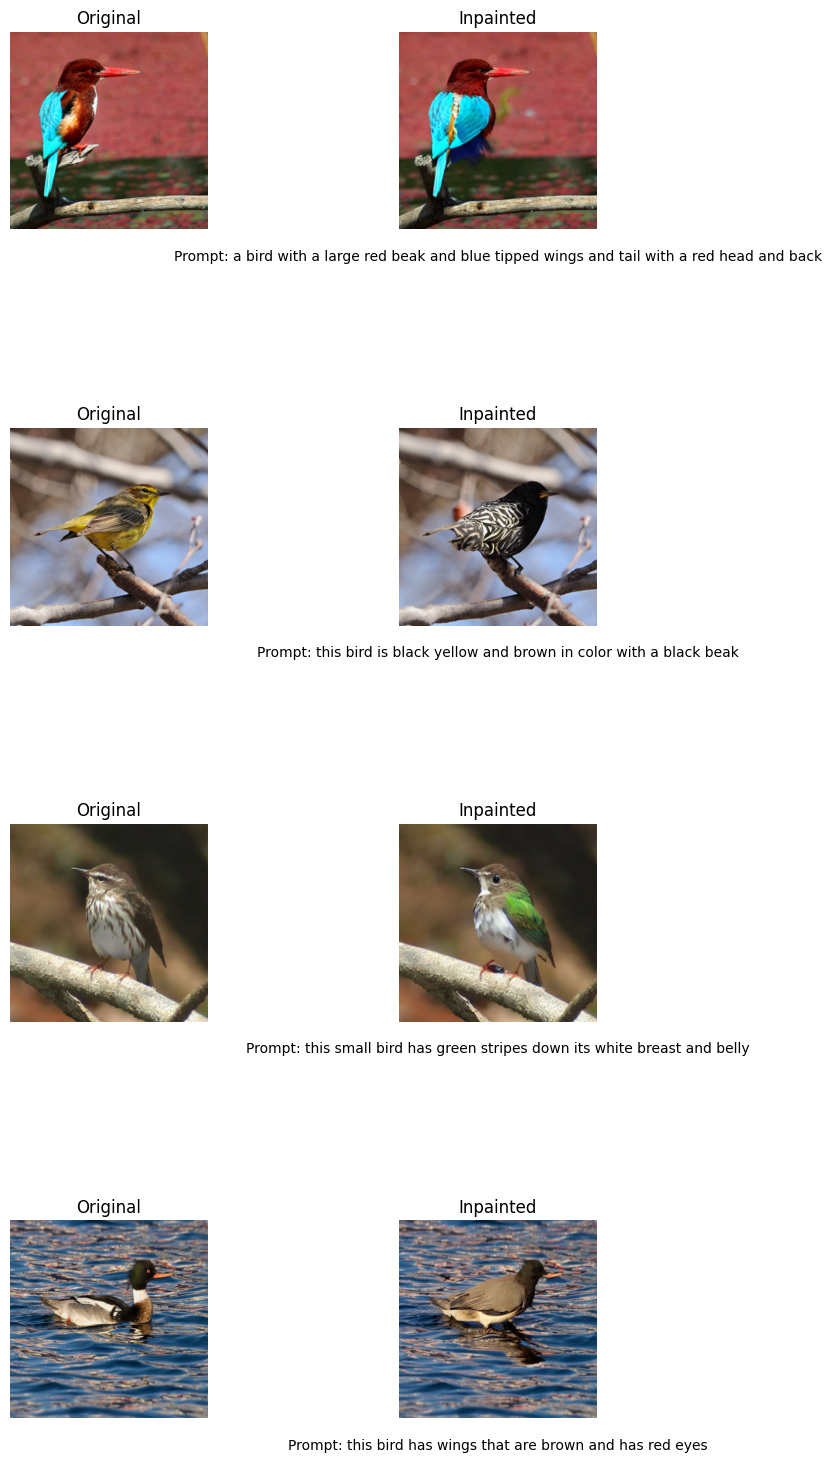

In [9]:
# Function to visualize results
def show_images(original, inpainted, prompts):
    fig, axes = plt.subplots(len(original), 2, figsize=(8, len(original) * 4))
    for i in range(len(original)):
        axes[i, 0].imshow(to_pil_image(original[i].cpu()))
        axes[i, 0].set_title("Original")
        axes[i, 1].imshow(inpainted[i])
        axes[i, 1].set_title("Inpainted")
        
        # Display the prompt below the inpainted image
        axes[i, 1].text(0.5, -0.1, f"Prompt: {prompts[i]}", ha='center', 
                        va='top', fontsize=10, transform=axes[i, 1].transAxes)
        
        for ax in axes[i]:
            ax.axis("off")
    plt.tight_layout()
    plt.show()

# Function to apply inpainting
def inpaint_batch(images, masks, prompts):
    inpainted_images = []
    for img, mask, prompt in zip(images, masks, prompts):
        inpainted_img = pipe(
            prompt=prompt,  # Use caption as prompt
            image=to_pil_image(img.cpu()),
            mask_image=to_pil_image(mask.cpu())
        ).images[0]
        inpainted_images.append(inpainted_img)
    return inpainted_images

# Get a batch of data
imgs, _, _, _, cap_texts = get_data(dataloader)  # Get images and captions
masks = get_mask()

# Apply inpainting with captions as prompts
inpainted_imgs = inpaint_batch(imgs, masks, cap_texts)

# Show results
show_images(imgs, inpainted_imgs, cap_texts)
